In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import seaborn as sns
import json
from datetime import datetime
from collections import Counter
from pyprojroot import here

## Style

In [191]:
colors=['#19bdff','#f2d138'] #majority/minority
greycolor='#626262'
myblack='#222222'
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



## Load data and estimate ratings

In [192]:
##import survey data from Sparkman et al.
df = pd.read_csv(here('data/survey_data/participant_data.csv'))

In [193]:
#create a copy of the dataframe to prevent altering the dataset
dfmedia=df.copy()

In [194]:
medialist=['CNN','NYT','ABC','NPR','FOX','Cons','Lib']

# add a column for each media category based on consuming once a week or more
dfmedia['CNN']=np.where((dfmedia["GRID_GTS3_1_GTS3"]>=3),True,False)
dfmedia['NYT']=np.where((dfmedia["GRID_GTS3_3_GTS3"]>=3),True,False)
dfmedia['ABC']=np.where((dfmedia["GRID_GTS3_4_GTS3"]>=3),True,False)
dfmedia['NPR']=np.where((dfmedia["GRID_GTS3_5_GTS3"]>=3),True,False)
dfmedia['FOX']=np.where((dfmedia["GRID_GTS3_6_GTS3"]>=3),True,False)
dfmedia['Cons']=np.where((dfmedia["GRID_GTS3_7_GTS3"]>=3),True,False)
dfmedia['Lib']=np.where((dfmedia["GRID_GTS3_8_GTS3"]>=3),True,False)

In [195]:
# convert ordinal variables to approximate number of days a month that they consume a given media channel
def weigh_by_freq(response):
    if response==1:
        return 0
    elif response==2:
        return 1 
    elif response==3:
        return 5
    elif response==4:
        return 15
    elif response==5:
        return 30
    else:
        return 0

#copy columns
alteredmedialist=['CNN_ord','','NYT_ord','ABC_ord','NPR_ord','FOX_ord','Cons_ord','Lib_ord'] #to account for skipping 2 in GTS3
for i in range(1,9):
    if i!=2:

        dfmedia[alteredmedialist[i-1]]=dfmedia["GRID_GTS3_"+str(i)+"_GTS3"]


ordinal_medialist=['CNN_ord','NYT_ord','ABC_ord','NPR_ord','FOX_ord','Cons_ord','Lib_ord']


for string in ordinal_medialist:
    dfmedia[string]=dfmedia[string].apply(weigh_by_freq)



In [196]:
def make_ratings(ordinal_medialist, rating_type="survey"):
    ratings_dict = {}
    synthetic_ratings = np.zeros(len(ordinal_medialist))

    if rating_type == "survey":
    
        ratings_dict = {}
        for i in range(len(ordinal_medialist)):
            column = ordinal_medialist[i]
            weighted_sum = (dfmedia[column] * dfmedia['Weight']).sum() # make sure to use the weights to make a nationally representative sample
            synthetic_ratings[i] = weighted_sum
            ratings_dict[medialist[i]] = weighted_sum

    elif rating_type == "survey_unweighted":

        for i in range(len(ordinal_medialist)):
            column = ordinal_medialist[i]
            unweighted_sum = dfmedia[column].sum()
            synthetic_ratings[i] = unweighted_sum
            ratings_dict[medialist[i]] = unweighted_sum


    elif rating_type == "april_primetime":
        return {
            "FOX": 2_200_000,           # 2.2M
            "MSNBC": 1_580_000,         # 1.58M
            "CNN": 913_000,             # 913K
            "ABC": 7_583_000,           # 7.583M
            "CBS": 4_392_000,           # 4.392M
            "NBC": 6_183_000,           # 6.183M
            "PBS": 989_000,             # annual avg for 2021
        }
    
    elif rating_type == "youtube_2023":
        ratings_dict = {
            "FOX": 14_839_464_315,
            "ABC": 12_985_125_977,
            "CBS": 4_380_217_227,
            "PBS": 2_220_425_184,
            "MSNBC": 10_428_519_286,
            "CNN": 14_208_712_681,
            "NBC": 5_549_250_698,
        }

    else:
        raise ValueError(f"Unknown rating_type: {rating_type}")

    return ratings_dict


In [197]:

with open(here('00_data_processing/output/Q1_counts.json'), 'r') as json_file:
    Q1_counts = json.load(json_file)

with open(here('00_data_processing/output/Q2_counts.json'), 'r') as json_file:
    Q2_counts = json.load(json_file)

with open(here('00_data_processing/output/Q3_counts.json'), 'r') as json_file:
    Q3_counts = json.load(json_file)


In [198]:
Q1_counts={key: Q1_counts[key] for key in sorted(Q1_counts.keys())}
Q2_counts={key: Q2_counts[key] for key in sorted(Q2_counts.keys())}
Q3_counts={key: Q3_counts[key] for key in sorted(Q3_counts.keys())}

In [199]:
def combine_counts(counts_dict):
    """
    Combine counts from different categories into grouped totals.

    This function aggregates counts from a dictionary of arrays representing 
    different news outlets into broader categories: cable liberal, TV news, and Fox.

    Parameters:
    -----------
    counts_dict : dict
        A dictionary where keys are news outlet names (e.g., 'CNN', 'MSNBC', 'ABC', etc.) 
        and values are arrays representing counts for those outlets.

    Returns:
    --------
    dict
        A new dictionary with the following keys:
        - 'cable_lib': Combined counts for 'CNN' and 'MSNBC'.
        - 'tv_news': Combined counts for 'ABC', 'CBS', and 'NBC'.
        - 'Fox': Counts for 'Fox'.
    """
    # Initialize a new dictionary to store aggregated counts
    new_dict = {}

    # Combine counts for cable liberal news (CNN and MSNBC)
    new_dict['cable_lib'] = np.array(counts_dict['CNN']) + np.array(counts_dict['MSNBC'])

    # Combine counts for traditional TV news (ABC, CBS, NBC)
    new_dict['tv_news'] = (
        np.array(counts_dict['ABC']) + np.array(counts_dict['CBS']) + np.array(counts_dict['NBC'])
    )

    # Include counts for Fox without modification
    new_dict['Fox'] = np.array(counts_dict['Fox'])

    # Return the aggregated dictionary
    return new_dict


In [200]:
def compute_weighted_counts(combined_counts_dict, ratings_dict):
    """
    Compute weighted counts for grouped categories based on ratings.

    This function takes combined counts of categories (e.g., cable liberal, TV news, Fox) 
    and applies a weighting based on predefined ratings for specific news outlets.

    Parameters:
    -----------
    combined_counts_dict : dict
        A dictionary with keys 'cable_lib', 'tv_news', and 'Fox', where each value is 
        a list or array of counts representing the aggregated data for those categories.
    ratings_dict : dict
        A dictionary where keys are news outlet names (e.g., 'CNN', 'ABC', 'FOX'), and 
        values are numeric ratings used as weights for the counts.

    Returns:
    --------
    dict
        A new dictionary with the same keys as `combined_counts_dict`:
        - 'cable_lib': Weighted counts for the cable liberal category.
        - 'tv_news': Weighted counts for the TV news category.
        - 'Fox': Weighted counts for Fox.
    """
    # Initialize a new dictionary to store weighted counts
    new_dict = {}

    # Apply CNN ratings to cable_lib counts
    new_dict['cable_lib'] = [item * ratings_dict['CNN'] for item in combined_counts_dict['cable_lib']]

    # Apply ABC ratings to tv_news counts
    new_dict['tv_news'] = [item * ratings_dict['ABC'] for item in combined_counts_dict['tv_news']]

    # Apply FOX ratings to Fox counts
    new_dict['Fox'] = [item * ratings_dict['FOX'] for item in combined_counts_dict['Fox']]

    # Return the dictionary with weighted counts
    return new_dict


In [201]:
Q1_combined_counts_dict=combine_counts(Q1_counts)

Q2_combined_counts_dict=combine_counts(Q2_counts)

Q3_combined_counts_dict=combine_counts(Q3_counts)

In [202]:

Q1_choices=["Acknowledges","Neutral","Denies","Debate","Unclear"]
Q2_choices=["Expresses climate concern","Neutral","Expresses opposition to climate concern","Debate","Unclear"]
Q3_choices=["Supports","Neutral","Opposes","Debate","Unclear","No mention"]

short_Q2_choices=['Concern',
 'Neutral',
 'Opposition',
 'Debate',
 'Unclear']


## Make stacked histogram for different ratings sources

In [203]:
def create_stacked_histogram(choices, weighted_counts, ax, title, colors=None):
    """
    Create a stacked bar chart on the provided axis.

    Parameters
    ----------
    choices : list of str
        The x-axis labels for each bar. For example, Q1_choices.
    weighted_counts : dict of category -> list of counts
        Each list should have the same length as `choices`, with counts per choice.
        For example: {"Fox": [100, 200, 300], "CNN": [80, 190, 250]}
    ax : matplotlib axis
        The axis to plot on
    title : str
        Panel title
    colors : list of colors, optional
        One color per category
    """
    n_choices = len(choices)
    bottom = [0] * n_choices  # initialize base of each stack to 0
    bars = []

    # if no colors, fallback to a default color cycle
    if colors is None:
        colors = ['#4e79a7', '#f8c115', '#a02f2e', '#59a14f', '#e15759', '#b07aa1', '#ff9da7']

    # for each category to stack
    for idx, (category, values) in enumerate(weighted_counts.items()):
        # values must match number of choices
        if len(values) != n_choices:
            raise ValueError(f"Category {category} has {len(values)} counts but expected {n_choices} matching the number of choices")

        bar = ax.bar(
            choices,
            values,
            bottom=bottom,
            color=colors[idx % len(colors)],
            label=category
        )
        bars.append(bar[0])

        # update bottom for next stack
        for i in range(n_choices):
            bottom[i] += values[i]
    
    ax.set_ylabel("Estimated views", color="#222222")
    ax.set_title(title, pad=20, color="#222222")
    ax.tick_params(axis="x", rotation=45, colors="#222222")
    ax.tick_params(axis="y", colors="#222222")
    for spine in ["top", "right", "left", "bottom"]:
        ax.spines[spine].set_color("#222222")

    return bars, bottom


In [204]:
Q3_choices_no_unclear=Q3_choices[:-2]+Q3_choices[-1:]


=== Plotting and reporting for rating: survey ===
Saved figure to 99_figures/weighted_by_views_survey.pdf


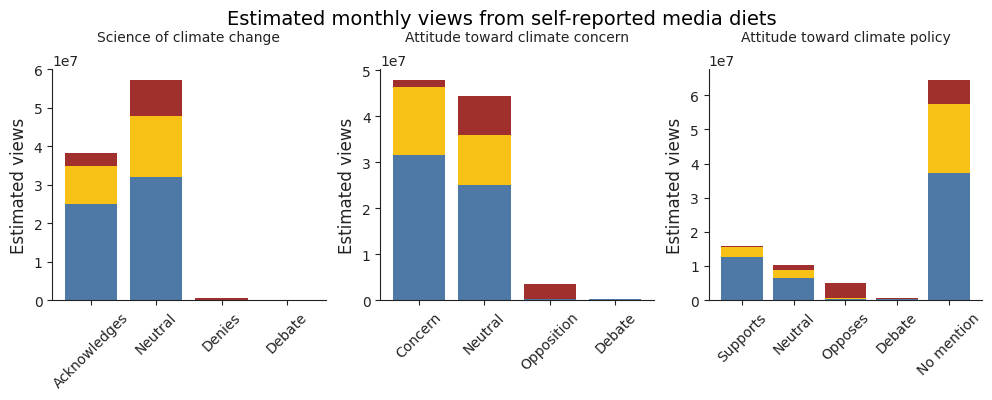

Q3 Support Ratios:
  cable_lib: support/(support+opposition) = 0.973, support/(s+n+o+d) = 0.644
  tv_news: support/(support+opposition) = 0.878, support/(s+n+o+d) = 0.503
  Fox: support/(support+opposition) = 0.063, support/(s+n+o+d) = 0.046
  TOTAL (all categories combined): support/(support+opposition) = 0.760, support/(s+n+o+d) = 0.501

=== Plotting and reporting for rating: survey_unweighted ===
Saved figure to 99_figures/weighted_by_views_survey_unweighted.pdf


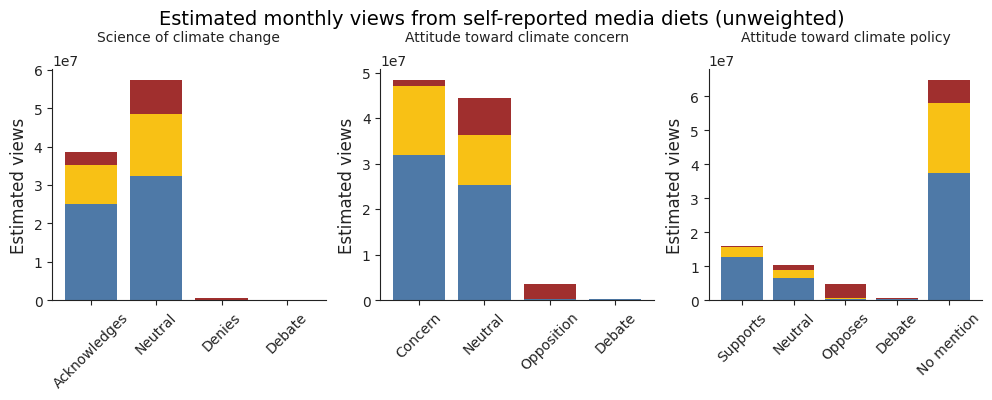

Q3 Support Ratios:
  cable_lib: support/(support+opposition) = 0.973, support/(s+n+o+d) = 0.644
  tv_news: support/(support+opposition) = 0.878, support/(s+n+o+d) = 0.503
  Fox: support/(support+opposition) = 0.063, support/(s+n+o+d) = 0.046
  TOTAL (all categories combined): support/(support+opposition) = 0.768, support/(s+n+o+d) = 0.505

=== Plotting and reporting for rating: april_primetime ===
Saved figure to 99_figures/weighted_by_views_april_primetime.pdf


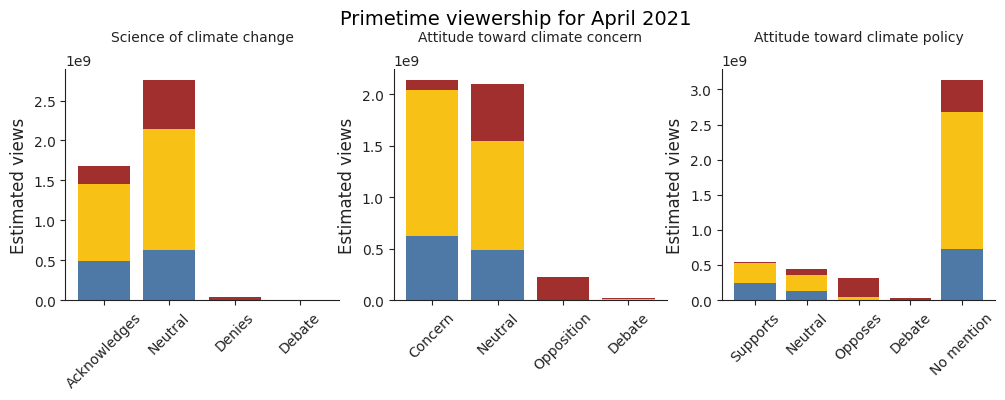

Q3 Support Ratios:
  cable_lib: support/(support+opposition) = 0.973, support/(s+n+o+d) = 0.644
  tv_news: support/(support+opposition) = 0.878, support/(s+n+o+d) = 0.503
  Fox: support/(support+opposition) = 0.063, support/(s+n+o+d) = 0.046
  TOTAL (all categories combined): support/(support+opposition) = 0.627, support/(s+n+o+d) = 0.405

=== Plotting and reporting for rating: youtube_2023 ===
Saved figure to 99_figures/weighted_by_views_youtube_2023.pdf


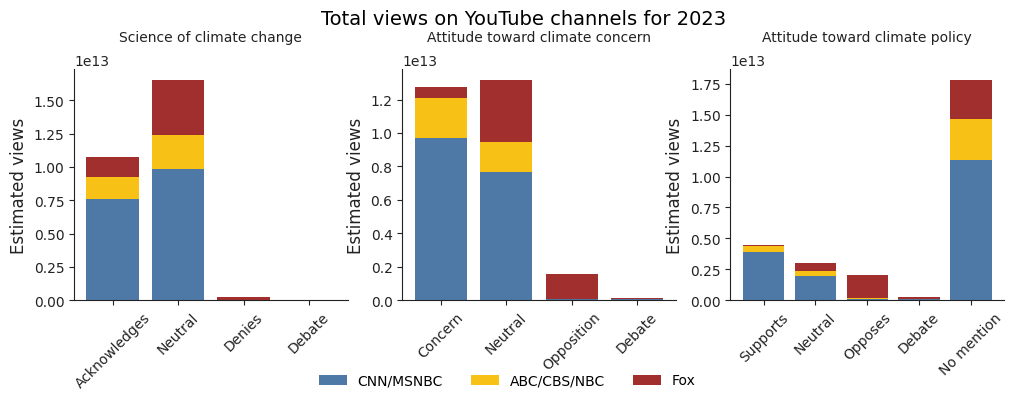

Q3 Support Ratios:
  cable_lib: support/(support+opposition) = 0.973, support/(s+n+o+d) = 0.644
  tv_news: support/(support+opposition) = 0.878, support/(s+n+o+d) = 0.503
  Fox: support/(support+opposition) = 0.063, support/(s+n+o+d) = 0.046
  TOTAL (all categories combined): support/(support+opposition) = 0.687, support/(s+n+o+d) = 0.461


In [205]:
# define the four rating options
rating_options = ["survey", "survey_unweighted", "april_primetime", "youtube_2023"]

# define the descriptive titles
rating_titles = {
    "survey": "Estimated monthly views from self-reported media diets",
    "survey_unweighted": "Estimated monthly views from self-reported media diets (unweighted)",
    "april_primetime": "Primetime viewership for April 2021",
    "youtube_2023": "Total views on YouTube channels for 2023"
}

for rating_type in rating_options:
    print(f"\n=== Plotting and reporting for rating: {rating_type} ===")
    
    # create ratings
    ratings_dict = make_ratings(ordinal_medialist, rating_type=rating_type)
    
    # recompute weighted counts
    Q1_weighted_counts = compute_weighted_counts(Q1_combined_counts_dict, ratings_dict)
    Q2_weighted_counts = compute_weighted_counts(Q2_combined_counts_dict, ratings_dict)
    Q3_weighted_counts = compute_weighted_counts(Q3_combined_counts_dict, ratings_dict)
    
    # plot 1x3 figure
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
    
    Q1_bars, Q1_totals = create_stacked_histogram(Q1_choices[:-1], Q1_weighted_counts, axes[0], "Science of climate change")
    Q2_bars, Q2_totals = create_stacked_histogram(short_Q2_choices[:-1], Q2_weighted_counts, axes[1], "Attitude toward climate concern")
    Q3_bars, Q3_totals = create_stacked_histogram(Q3_choices_no_unclear, Q3_weighted_counts, axes[2], "Attitude toward climate policy")
    
    # suptitle with descriptive text
    suptitle = rating_titles.get(rating_type, rating_type)
    fig.suptitle(suptitle, fontsize=14, y=1.08)
    

    # consistent legend
    bars = Q1_bars
    labels = ['CNN/MSNBC', 'ABC/CBS/NBC', 'Fox']
    if rating_type == "youtube_2023":
        fig.legend(bars, labels, loc='lower center', ncol=len(labels), frameon=False)
    sns.despine()
    # plt.tight_layout(rect=[0, 0.05, 1, 1])
    
    # save
    save_path = f"99_figures/weighted_by_views_{rating_type}.pdf"
    plt.savefig(here(save_path), bbox_inches='tight', dpi=300)
    print(f"Saved figure to {save_path}")
    
    plt.show()
    
    # compute and print Q3 support ratios
    print("Q3 Support Ratios:")
    
    total_support = 0
    total_opposition = 0
    total_neutral = 0
    total_debate = 0
    
    for category in Q3_weighted_counts:
        support = Q3_weighted_counts[category][0]
        neutral = Q3_weighted_counts[category][1]
        opposition = Q3_weighted_counts[category][2]
        debate = Q3_weighted_counts[category][3]
        
        sp_opp_total = support + opposition
        ratio_so = support / sp_opp_total if sp_opp_total != 0 else float('nan')
        
        denom_all = support + neutral + opposition + debate
        ratio_all = support / denom_all if denom_all != 0 else float('nan')
        
        print(f"  {category}: support/(support+opposition) = {ratio_so:.3f}, support/(s+n+o+d) = {ratio_all:.3f}")
        
        total_support += support
        total_opposition += opposition
        total_neutral += neutral
        total_debate += debate
        
    grand_total_so = total_support + total_opposition
    grand_total_all = total_support + total_neutral + total_opposition + total_debate
    
    total_ratio_so = total_support / grand_total_so if grand_total_so != 0 else float('nan')
    total_ratio_all = total_support / grand_total_all if grand_total_all != 0 else float('nan')


    
    print(f"  TOTAL (all categories combined): support/(support+opposition) = {total_ratio_so:.3f}, support/(s+n+o+d) = {total_ratio_all:.3f}")
